### Import tensorflow and additional libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()

#Check version
print('tensorflow version:',tf.__version__)

tensorflow version: 2.2.0


### Load fashion MNIST dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train = len(train_images)
size_of_test = len(test_images)
num_of_class = 10

print("The number of train images:",size_of_train)
print("The number of test images:",size_of_test)

4423680/4422102 [==============================] - 0s 0us/step
The number of train images: 60000
The number of test images: 10000


### Preprocess data

In [3]:
print('==Before normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)

##Dataset Pre-processing##
#Normalization
train_images= train_images/255.
test_images =test_images/255.

#Reshape(Adding chaneel)
train_images = train_images.reshape((size_of_train,28,28,1))
test_images = test_images.reshape((size_of_test,28,28,1))

#Convet label
train_labels = tf.keras.utils.to_categorical(train_labels,num_of_class)
test_labels = tf.keras.utils.to_categorical(test_labels,num_of_class)

print('==Afte normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)

==Before normalization==
Image Shape: (60000, 28, 28)
Value MIN: 0, MEAN:97.25, MAX:255
[9 0 0 ... 3 0 5]
==Afte normalization==
Image Shape: (60000, 28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Define channel & spatial attention module, residual block, model builder

In [0]:
def channel_attention(x, r = 4):  
    ch = x.shape[-1]
    ch_reduced = ch/r
    
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(x)

    excitation = tf.keras.layers.Dense(ch_reduced)(squeeze)
    excitation = tf.keras.layers.ReLU()(excitation)
    excitation = tf.keras.layers.Dense(ch, activation='sigmoid')(excitation)
    
    output = tf.keras.layers.Multiply()([x, excitation])

    return  output

def spatial_attention(x): 
    
    conv = tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1, 1), padding='same', activation='sigmoid')(x)

    output = tf.keras.layers.Multiply()([x, conv])
    
    return  output

def attention_module(x, attention_type):
    if attention_type is 'channel':
        x = channel_attention(x)
        output = x
        
    elif attention_type is 'spatial':
        x = spatial_attention(x)
        output = x
        
    elif attention_type is 'parellel_add':
        ca = channel_attention(x)
        sa = spatial_attention(x)
        x = tf.keras.layers.Add()([ca, sa])
        output = x

    elif attention_type is 'parellel_mul':
        ca = channel_attention(x)
        sa = spatial_attention(x)
        x = tf.keras.layers.Multiply()([ca, sa])
        output = x

    elif attention_type is 'serial_ca':
        x = channel_attention(x)
        x = spatial_attention(x)
        output = x

    elif attention_type is 'serial_sa':
        x = spatial_attention(x)
        x = channel_attention(x)
        output = x

    else:
        output  = x
    
    return output

def res_block(x, filter, stride, name):
    input = x
    # downsizing by stride
    if stride != 1:
        input = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,name=name+'_pooling_conv')(input)
        input = tf.keras.layers.BatchNormalization(name=name+'_pooling_bn')(input)

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,padding='same',name=name+'_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn1')(x)
    x = tf.nn.relu(x,name=name+'_relu1')

    # strides : 1
    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=1,padding='same',name=name+'_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn2')(x)
    # residual connection
    x = tf.keras.layers.add([input,x],name=name+'_add')

    x = tf.nn.relu(x,name=name+'_relu2')
    return x

def model_builder(x, attention):
    #######################
    #Add Attention Module #
    
    # conv 1
    # (28x28x1) > (14x14x64)
    x = tf.keras.layers.Conv2D(filters=64,kernel_size=7,strides=2,activation='relu',padding='same',name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='conv1_bn')(x)
    # (14x14x64) > (7x7x64)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same',name='conv1_max_pool')(x)
    # residual 1_1 & 1_2
    # (7x7x64) > (4x4x64)
    x = res_block(x,64,2,'ResBlock21')
    x = attention_module(x, attention)
    x = res_block(x,64,1,'ResBlock22')
    x = attention_module(x, attention)
    # residual 2_1 & 2_2
    # (4x4x64) > (2x2x128)
    x = res_block(x,128,2,'ResBlock31')
    x = attention_module(x, attention)
    x = res_block(x,128,1,'ResBlock32')

    # (, 128)
    x =tf.keras.layers.GlobalAveragePooling2D(name='GAP')(x) 
    pred = tf.keras.layers.Dense(num_of_class,activation='softmax')(x)
    
    return pred

### Define Input & Outputs

### Build models

In [5]:
inputs = tf.keras.Input(shape=(28,28,1))

pred_normal = model_builder(inputs,None)

pred_channel = model_builder(inputs,attention='channel')
pred_spatial = model_builder(inputs,attention='spatial')
pred_parellel_add = model_builder(inputs,attention='parellel_add')
pred_parellel_mul = model_builder(inputs,attention='parellel_mul')
pred_serial_ca = model_builder(inputs,attention='serial_ca')
pred_serial_sa = model_builder(inputs,attention='serial_sa')

model_normal = tf.keras.Model(inputs=inputs,outputs=pred_normal)
model_channel = tf.keras.Model(inputs=inputs,outputs=pred_channel)
model_spatial = tf.keras.Model(inputs=inputs,outputs=pred_spatial)
model_parellel_add = tf.keras.Model(inputs=inputs,outputs=pred_parellel_add)
model_parellel_mul = tf.keras.Model(inputs=inputs,outputs=pred_parellel_mul)
model_serial_ca = tf.keras.Model(inputs=inputs,outputs=pred_serial_ca)
model_serial_sa = tf.keras.Model(inputs=inputs,outputs=pred_serial_sa)

model_normal.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_max_pool (MaxPooling2D)   (None, 7, 7, 64)     0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Compile models

In [0]:
#Select optimizer and compile Model
optimizer = tf.keras.optimizers.Adam()
model_normal.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_channel.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_spatial.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_add.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_mul.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_ca.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_sa.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

### Train models

In [7]:
#Train Normal Model
print('Training Normal Model')
hist_normal = model_normal.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Channel Attention Model
print()
print('Training Channel Attention Model')
hist_channel = model_channel.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Spatial Attention Model
print()
print('Training Spatial Attention Model')
hist_spatial = model_spatial.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Parelle add  Model
print()
print('Training Parelle add  Model')
hist_parellel_add = model_parellel_add.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Parellel Mul Model
print()
print('Training  Parellel Mul Model')
hist_parellel_mul = model_parellel_mul.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Serial CA Model
print()
print('Training Serial CA Model')
hist_serial_ca = model_serial_ca.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Serial SA Model
print()
print('Training Serial SA Model')
hist_serial_sa = model_serial_sa.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

Training Normal Model
Epoch 1/30
3750/3750 [==============================] - 20s 5ms/step - loss: 0.5469 - accuracy: 0.8000 - val_loss: 0.5402 - val_accuracy: 0.8078
Epoch 2/30
3750/3750 [==============================] - 20s 5ms/step - loss: 0.4356 - accuracy: 0.8389 - val_loss: 0.4506 - val_accuracy: 0.8253
Epoch 3/30
3750/3750 [==============================] - 20s 5ms/step - loss: 0.3949 - accuracy: 0.8535 - val_loss: 0.4140 - val_accuracy: 0.8473
Epoch 4/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.3681 - accuracy: 0.8633 - val_loss: 0.4063 - val_accuracy: 0.8494
Epoch 5/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.3501 - accuracy: 0.8692 - val_loss: 0.4662 - val_accuracy: 0.8277
Epoch 6/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.3370 - accuracy: 0.8740 - val_loss: 0.3752 - val_accuracy: 0.8610
Epoch 7/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.3231 - accuracy: 0.8801 - val

### Plot train & validation loss

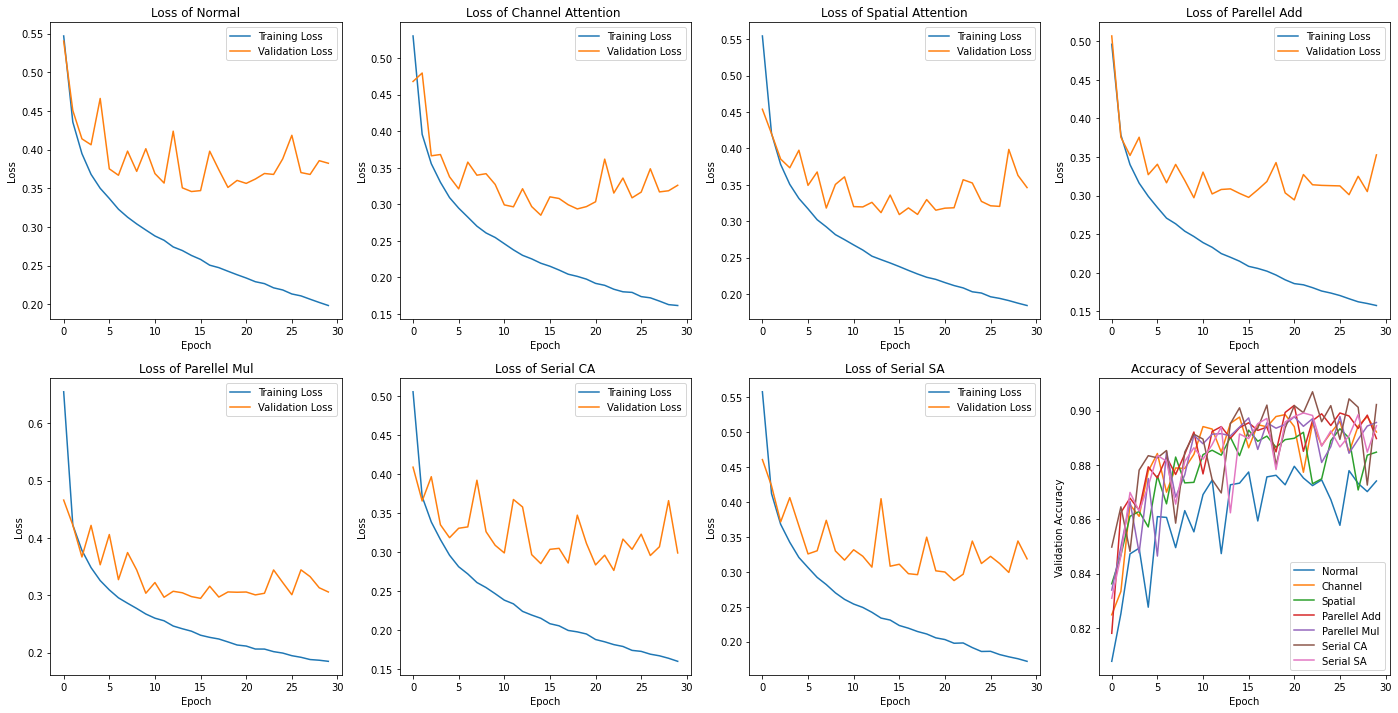

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(hist_normal.history['loss'])
plt.plot(hist_normal.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(hist_channel.history['loss'])
plt.plot(hist_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(hist_spatial.history['loss'])
plt.plot(hist_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(hist_parellel_add.history['loss'])
plt.plot(hist_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(hist_parellel_mul.history['loss'])
plt.plot(hist_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(hist_serial_ca.history['loss'])
plt.plot(hist_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(hist_serial_sa.history['loss'])
plt.plot(hist_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(hist_normal.history['val_accuracy'])
plt.plot(hist_channel.history['val_accuracy'])
plt.plot(hist_spatial.history['val_accuracy'])
plt.plot(hist_parellel_add.history['val_accuracy'])
plt.plot(hist_parellel_mul.history['val_accuracy'])
plt.plot(hist_serial_ca.history['val_accuracy'])
plt.plot(hist_serial_sa.history['val_accuracy'])

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()

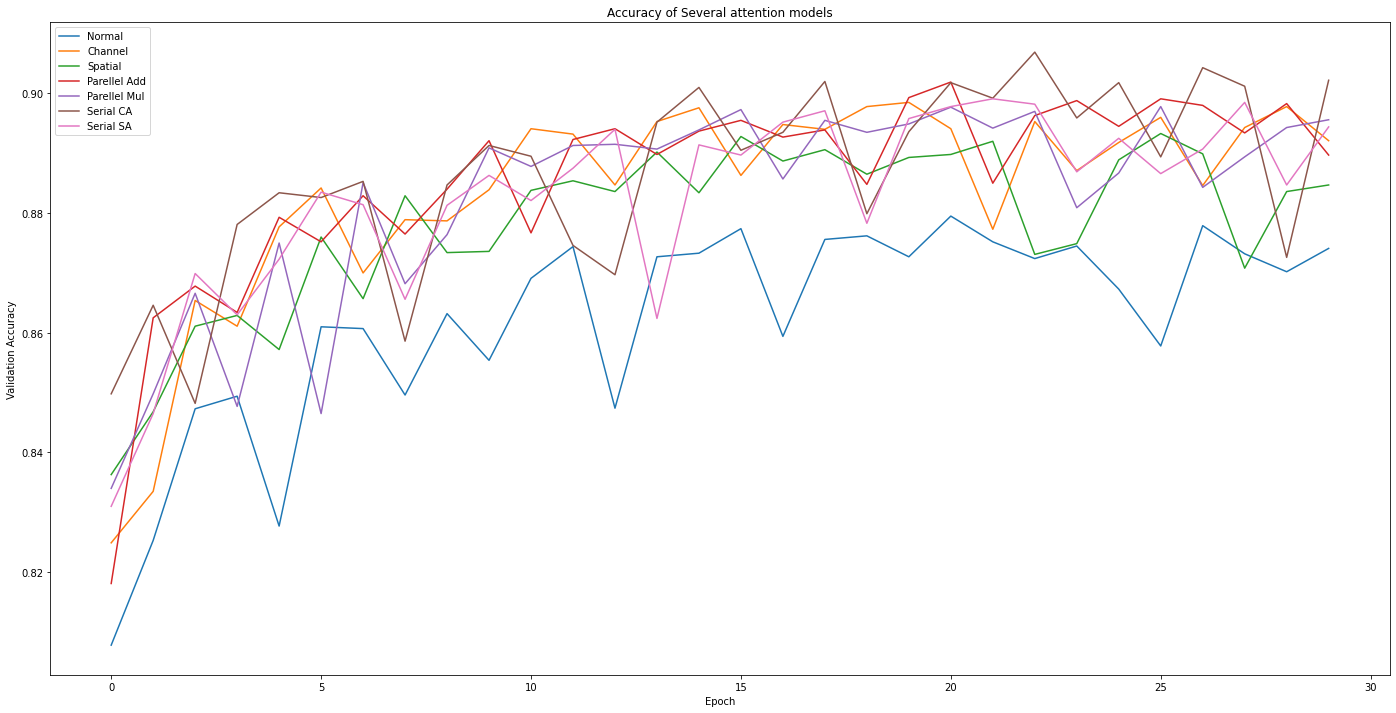

In [9]:
plt.figure(figsize=(24,12))
plt.plot(hist_normal.history['val_accuracy'])
plt.plot(hist_channel.history['val_accuracy'])
plt.plot(hist_spatial.history['val_accuracy'])
plt.plot(hist_parellel_add.history['val_accuracy'])
plt.plot(hist_parellel_mul.history['val_accuracy'])
plt.plot(hist_serial_ca.history['val_accuracy'])
plt.plot(hist_serial_sa.history['val_accuracy'])

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()